In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler,MaxAbsScaler,Normalizer
import torch,torchvision
from torch.nn import *
from torch.optim import *
import cv2
PROJECT_NAME = 'Dogecoin-Price-Prediction'
device = 'cuda'

In [2]:
data = pd.read_csv('./data.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-24,0.001731,0.001845,0.001722,0.001816,0.001816,4796720.0
1,2017-08-25,0.001808,0.001830,0.001762,0.001790,0.001790,2654040.0
2,2017-08-26,0.001787,0.001797,0.001735,0.001778,0.001778,1935350.0
3,2017-08-27,0.001779,0.001784,0.001745,0.001760,0.001760,2241620.0
4,2017-08-28,0.001764,0.001825,0.001751,0.001825,0.001825,3210440.0


In [4]:
data = data['Open']

In [5]:
data = torch.from_numpy(np.array(data.tolist())).view(1,-1)

In [6]:
data_input = data[:3,:-1].float()
data_target = data[:3,1:].float()

In [7]:
class Model(Module):
    def __init__(self,hidden=128):
        super().__init__()
        self.hidden = hidden
        self.lstm1 = LSTMCell(1,hidden).to(device)
        self.lstm2 = LSTMCell(hidden,hidden).to(device)
        self.lstm3 = LSTMCell(hidden,hidden).to(device)
        self.linear1 = Linear(hidden,1).to(device)
    
    def forward(self,X,future=0):
        preds = []
        batch_size = X.size(0)
        h_t1 = torch.zeros(batch_size,self.hidden,dtype=torch.float32)
        c_t1 = torch.zeros(batch_size,self.hidden,dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.hidden,dtype=torch.float32)
        c_t2 = torch.zeros(batch_size,self.hidden,dtype=torch.float32)
        h_t3 = torch.zeros(batch_size,self.hidden,dtype=torch.float32)
        c_t3 = torch.zeros(batch_size,self.hidden,dtype=torch.float32)
        h_t1 = h_t1.to(device)
        c_t1 = c_t1.to(device)
        h_t2 = h_t2.to(device)
        c_t2 = c_t2.to(device)
        h_t3 = h_t3.to(device)
        c_t3 = c_t3.to(device)
        for X_batch in X.split(1,dim=1):
            X_batch = X_batch.to(device)
            h_t1,c_t1 = self.lstm1(X_batch,(h_t1,c_t1))
            h_t1 = h_t1.to(device)
            c_t1 = c_t1.to(device)
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            h_t3,c_t3 = self.lstm3(h_t2,(h_t3,c_t3))
            h_t3 = h_t3.to(device)
            c_t3 = c_t3.to(device)
            pred = self.linear1(h_t3)
            preds.append(pred)
        for i in range(future):
            h_t1,c_t1 = self.lstm1(X_batch,(h_t1,c_t1))
            h_t1 = h_t1.to(device)
            c_t1 = c_t1.to(device)
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            h_t3,c_t3 = self.lstm3(h_t2,(h_t3,c_t3))
            h_t3 = h_t3.to(device)
            c_t3 = c_t3.to(device)
            pred = self.linear1(h_t3)
            preds.append(pred)
        preds = torch.cat(preds,dim=1)
        return preds

In [8]:
model = Model()
optimizer = LBFGS(model.parameters(),lr=0.8)
criterion = MSELoss()

In [9]:
epochs = 100

In [10]:
from tqdm import tqdm

In [11]:
import wandb

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


  0%|          | 0/100 [00:23<?, ?it/s]


ValueError: x and y must have same first dimension, but have shapes (1461,) and (100,)

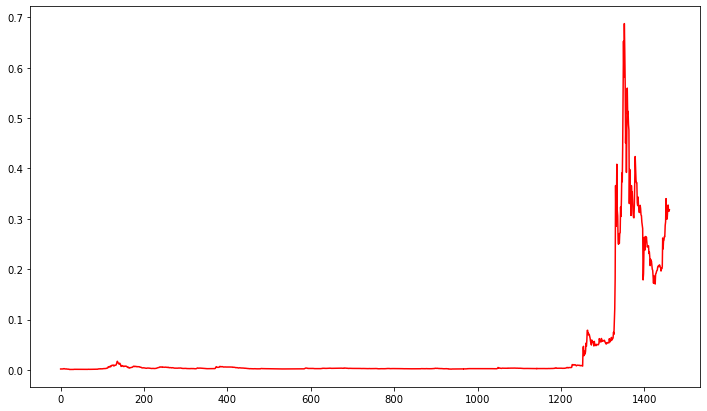

In [12]:
wandb.init(project=PROJECT_NAME,name='baseline')
wandb.watch(model)
for _ in tqdm(range(epochs)):
    def closure():
        optimizer.zero_grad()
        preds = model(data_input)
        loss = criterion(preds.to(device),data_target.to(device))
        wandb.log({'Loss':loss.item()})
        loss.backward()
        return loss
    optimizer.step(closure)
    with torch.no_grad():
        future = 100
        preds = model(data_input,future)
        loss = criterion(preds[:,:-future].to(device),data_target.to(device))
        wandb.log({'Val Loss':loss.item()})
        preds = preds.cpu().detach().numpy()
    plt.figure(figsize=(12,7))
    n = data_input.shape[1]
    plt.plot(np.arange(n),data_target.cpu().view(-1).detach().numpy(),'r')
    plt.plot(np.arange(n),preds[0][n:],'b')
    plt.savefig('./plot.png')
    plt.close()
    wandb.log({'Preds':wandb.Image(cv2.imread('./plot.png'))})
wandb.watch(model)
wandb.finish()

In [ ]:
preprocessings = [StandardScaler,RobustScaler,MinMaxScaler,MaxAbsScaler,Normalizer]

In [ ]:
for preprocessing in preprocessings:
    model = Model()
    optimizer = LBFGS(model.parameters(),lr=0.8)
    criterion = MSELoss()
    wandb.init(project=PROJECT_NAME,name=f'{preprocessing}-preprocessing')
    wandb.watch(model)
    for _ in tqdm(range(epochs)):
        def closure():
            optimizer.zero_grad()
            preds = model(data_input)
            loss = criterion(preds,data_target)
            wandb.log({'Loss':loss.item()})
            loss.backward()
            return loss
        optimizer.step(closure)
        with torch.no_grad():
            future = 100
            preds = model(data_input,future)
            loss = criterion(preds,data_target)
            wandb.log({'Val Loss':loss.item()})
            preds = preds.cpu().detach().numpy()
        plt.figure(figsize=(12,7))
        n = data_input.shape[1]
        plt.plot(np.arange(n),data_target.cpu().view(-1).detach().numpy(),'r')
        plt.plot(np.arange(n),preds[0][n:],'b')
        plt.savefig('./plot.png')
        plt.close()
        wandb.log({'Preds':wandb.Image(cv2.imread('./plot.png'))})
    wandb.watch(model)
    wandb.finish()

In [ ]:
hiddens = [16,32,64,128,256,512]

In [ ]:
for hidden in hiddens:
    model = Model(hidden)
    optimizer = LBFGS(model.parameters(),lr=0.8)
    criterion = MSELoss()
    wandb.init(project=PROJECT_NAME,name=f'{hidden}-hidden')
    wandb.watch(model)
    for _ in tqdm(range(epochs)):
        def closure():
            optimizer.zero_grad()
            preds = model(data_input)
            loss = criterion(preds,data_target)
            wandb.log({'Loss':loss.item()})
            loss.backward()
            return loss
        optimizer.step(closure)
        with torch.no_grad():
            future = 100
            preds = model(data_input,future)
            loss = criterion(preds,data_target)
            wandb.log({'Val Loss':loss.item()})
            preds = preds.cpu().detach().numpy()
        plt.figure(figsize=(12,7))
        n = data_input.shape[1]
        plt.plot(np.arange(n),data_target.cpu().view(-1).detach().numpy(),'r')
        plt.plot(np.arange(n),preds[0][n:],'b')
        plt.savefig('./plot.png')
        plt.close()
        wandb.log({'Preds':wandb.Image(cv2.imread('./plot.png'))})
    wandb.watch(model)
    wandb.finish()

In [ ]:
lrs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [ ]:
for lr in lrs:
    model = Model()
    optimizer = LBFGS(model.parameters(),lr=lr)
    criterion = MSELoss()
    wandb.init(project=PROJECT_NAME,name=f'{lr}-lr')
    wandb.watch(model)
    for _ in tqdm(range(epochs)):
        def closure():
            optimizer.zero_grad()
            preds = model(data_input)
            loss = criterion(preds,data_target)
            wandb.log({'Loss':loss.item()})
            loss.backward()
            return loss
        optimizer.step(closure)
        with torch.no_grad():
            future = 100
            preds = model(data_input,future)
            loss = criterion(preds,data_target)
            wandb.log({'Val Loss':loss.item()})
            preds = preds.cpu().detach().numpy()
        plt.figure(figsize=(12,7))
        n = data_input.shape[1]
        plt.plot(np.arange(n),data_target.cpu().view(-1).detach().numpy(),'r')
        plt.plot(np.arange(n),preds[0][n:],'b')
        plt.savefig('./plot.png')
        plt.close()
        wandb.log({'Preds':wandb.Image(cv2.imread('./plot.png'))})
    wandb.watch(model)
    wandb.finish()